In [1]:
import os
import noisereduce as nr
from scipy.io import wavfile
import numpy as np


In [2]:
# get location of audio files
root_directory = os.getcwd()
audio_directory = os.path.join(root_directory, 'dataset')
nr_directory = os.path.join(root_directory, 'dataset_NR')
os.makedirs(nr_directory, exist_ok=True)

In [3]:
for root, _, files in os.walk(audio_directory):
    relative_path = os.path.relpath(root, audio_directory)
    save_directory = os.path.join(nr_directory, relative_path)
    os.makedirs(save_directory, exist_ok=True)
    print(f"Created directory: {save_directory}")
    
    for file_name in files:
        file_path = os.path.join(root, file_name)
        if file_name.endswith('.wav'):
            rate, data = wavfile.read(file_path)
            # 1) data is mono-channel
            if data.ndim == 1:
                reduced_noise = nr.reduce_noise(y=data, sr=rate)
            # 2) data is multi-channel
            else:
                reduced_noise = []
                for i in range(data.shape[1]):
                    reduced_channel = nr.reduce_noise(y=data[:, i], sr=rate)
                    reduced_noise.append(reduced_channel)
                reduced_noise = np.stack(reduced_noise, axis=1)
            reduced_noise = reduced_noise.astype(data.dtype)
            reduce_name = f'{os.path.splitext(file_name)[0]}_NR.wav'
            wavfile.write(os.path.join(save_directory, reduce_name), rate, reduced_noise)
    print(f"Completed noise reduction for files in folder {root}")

Created directory: e:\CS4641\Project\dataset_NR\.
Completed noise reduction for files in folder e:\CS4641\Project\dataset
Created directory: e:\CS4641\Project\dataset_NR\Actor_01


C:\Users\iamlm\AppData\Local\Temp\ipykernel_21804\1555821014.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = wavfile.read(file_path)


Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_01
Created directory: e:\CS4641\Project\dataset_NR\Actor_01_NR
Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_01_NR
Created directory: e:\CS4641\Project\dataset_NR\Actor_02
Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_02
Created directory: e:\CS4641\Project\dataset_NR\Actor_02_NR
Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_02_NR
Created directory: e:\CS4641\Project\dataset_NR\Actor_03
Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_03
Created directory: e:\CS4641\Project\dataset_NR\Actor_03_NR
Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_03_NR
Created directory: e:\CS4641\Project\dataset_NR\Actor_04
Completed noise reduction for files in folder e:\CS4641\Project\dataset\Actor_04
Created directory: e:\CS4641\Project\dataset_NR\Actor_04_NR
Completed noi

In [4]:
import os
import re
import librosa
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

In [5]:
def pad_signal(signal, target_length=512):
    if len(signal) < target_length:
        padding = target_length - len(signal)
        signal = np.pad(signal, (0, padding), 'constant')
    return signal

In [6]:
def extract_features(file_path, sample_rate=48000, n_fft=512):
    signal, sr = librosa.load(file_path, sr=sample_rate)
    signal = librosa.effects.trim(signal)[0]
    signal = pad_signal(signal, target_length=n_fft)

    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=n_fft).T, axis=0)
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=signal, sr=sr, n_fft=n_fft), axis=1)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40, n_fft=n_fft), axis=1)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=n_fft))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=n_fft))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=n_fft), axis=1)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=n_fft))

    tonnetz = np.mean(librosa.feature.tonnetz(y=signal, sr=sr), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal))
    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=signal, sr=sr), axis=1)
    chroma_cens = np.mean(librosa.feature.chroma_cens(y=signal, sr=sr), axis=1)
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=signal))
    rms = np.mean(librosa.feature.rms(y=signal))

    features = np.hstack([
        mfccs, chroma_stft, mel_spectrogram, spectral_centroid, spectral_bandwidth, 
        tonnetz, zcr, chroma_cqt, chroma_cens, spectral_contrast, 
        spectral_flatness, spectral_rolloff, rms
    ])

    return features

In [7]:
# function that creates sklearn dataset
# input: audio_directory = path of audio data
# output: original_dataset = dataset of features, labels = labels
def create_dataset(audio_directory):
    file_paths = []
    labels = []

    # pattern to match folder and file names(avoid file errors)
    folderPattern = re.compile(r"Actor_\d{2}")
    filePattern = re.compile(r"\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}_NR\.wav")

    for root, _, files in os.walk(audio_directory):
        if folderPattern.match(os.path.basename(root)):
            for file_name in files:
                if filePattern.match(file_name):
                    emotion = int(file_name.split("-")[2])
                    labels.append(emotion)
                    file_paths.append(os.path.join(root, file_name))

    # get features for all files
    all_features = []
    for file in file_paths:
        all_features.append(extract_features(file))

    # convert list of features and labels to np array and create dataset
    all_features = np.array(all_features)
    labels = np.array(labels)
    original_dataset = Bunch(
        data=all_features,
        target=labels,
    )

    return original_dataset, labels

In [8]:
# function that  that runs PCA on sklearn dataset
# input: orig_dataset = original dataset of features, labels = labels, target_variance = default 0.95
# output: pca_features_reduced = reduced dataset of features, labels = labels
def pca_dataset(orig_dataset, labels, target_variance=0.95):
    # # standardize dataset and apply PCA
    scaler = StandardScaler()
    if orig_dataset.data.ndim == 1:
        orig_dataset.data = orig_dataset.data.reshape(-1, 1)
    if orig_dataset.data.shape[0] == 0:
        print("Error: The dataset is empty.")
        return None, None
    all_features_scaled = scaler.fit_transform(orig_dataset.data)
    pca = PCA(target_variance)
    pca_features_reduced = pca.fit_transform(all_features_scaled)

    print(f"Original number of features: {orig_dataset.data.shape[1]}")
    print(f"Reduced number of features with {target_variance * 100}% variance retained: {pca_features_reduced.shape[1]}")

    return pca_features_reduced, labels

In [9]:
# get original dataset
orig_data, labels = create_dataset(nr_directory)

d:\Anaconda\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=548
  warnings.warn(
d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=564
  warnings.warn(
d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=960
  warnings.warn(
d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=480
  warnings.warn(
d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=912
  w

In [10]:
# run PCA and get reduced dataset
reduced_data, labels = pca_dataset(orig_data, labels)
print(reduced_data)
print(labels)

Original number of features: 108
Reduced number of features with 95.0% variance retained: 37
[[-1.27773346 -2.82773822  1.80648151 ... -0.35516078 -0.42449249
   0.24444848]
 [-1.20357996 -2.98525203 -0.06211738 ... -0.40809145  0.04675045
  -0.13840615]
 [-0.52483636 -4.58894483  2.96191542 ...  0.38410863 -0.213815
  -0.16883812]
 ...
 [ 1.31293709 -0.86768734  1.67392498 ... -0.05303022  0.03540323
   0.51304905]
 [ 5.57101162  3.40708664 -1.26646196 ...  0.39273567  1.79069351
   0.03807711]
 [ 3.7554743  -0.15710053  0.18974089 ...  0.75833831  0.89042656
   0.63662183]]
[1 1 1 ... 8 8 8]


In [11]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [12]:
def remove_ds_store_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

remove_ds_store_files(audio_directory)

In [13]:
data_dir = audio_directory
file_paths = []
labels = []

for actor_dir in sorted(os.listdir(data_dir)):
    actor_path = os.path.join(data_dir, actor_dir)
    for file_name in sorted(os.listdir(actor_path)):
        file_path = os.path.join(actor_path, file_name)
        emotion = int(file_name.split("-")[2])
        labels.append(emotion)
        file_paths.append(file_path)

In [14]:
def add_noise(signal, noise_factor=0.035):
    noise = np.random.normal(0, 1, signal.shape)
    amplitude = noise_factor * np.max(signal)
    noisy_data = signal + amplitude * noise
    return noisy_data

def stretch(signal, rate=0.7):
    return librosa.effects.time_stretch(y=signal, rate=rate)

def shift(signal, shift_range=(-5, 5)):
    shift_amount = np.random.randint(*shift_range) * 1000
    return np.roll(signal, shift_amount)

def pitch(signal, sampling_rate=48000, step=1):
    return librosa.effects.pitch_shift(y=signal, sr=sampling_rate, n_steps=step)

In [15]:
def extract_features(file_path, to_add_noise=False, to_stretch=False, to_shift=False, to_pitch=False, sample_rate=48000):
    signal, sr = librosa.load(file_path, sr=sample_rate)
    signal, _  = librosa.effects.trim(signal)
    
    if to_add_noise:
        signal = add_noise(signal)
    if to_stretch:
        signal = stretch(signal)
    if to_shift:
        signal = shift(signal)
    if to_pitch:
        signal = pitch(signal)
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal, frame_length=512))
    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=5, n_fft=512).T, axis=0)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=512))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=512), axis=1)
    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=signal, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=signal, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=signal, frame_length=512))
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=10, n_fft=512), axis=1)
    
    features = np.hstack([zcr, mfccs, spectral_rolloff, spectral_contrast, chroma_cqt, tonnetz, rms, mel_spectrogram])
    return features

In [16]:
print(extract_features(file_paths[1], to_pitch=True))
print(extract_features(file_paths[1], to_pitch=False))

d:\Anaconda\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=892
  warnings.warn(


[ 1.48315430e-01 -8.50023132e+02  5.62338486e+01 -1.89763546e+01
  6.43742800e+00  9.09646034e+00  1.00015346e+04  4.22265367e+00
  2.86959679e+00  6.55011638e+00  9.30213179e+00  1.19023251e+01
  1.64447388e+01  4.15373082e+01  4.17905480e-01  4.34653252e-01
  4.87610638e-01  4.20891136e-01  4.34685558e-01  4.14236575e-01
  5.15737116e-01  4.35889989e-01  3.93866748e-01  4.48291242e-01
  5.13702631e-01  6.36532903e-01  2.18513640e-02 -3.67294277e-02
  3.65161422e-02 -6.43704149e-02 -8.26889265e-03 -8.79633340e-05
  1.91765837e-03  6.90856308e-04  2.92985700e-04  7.20406169e-05
  3.13020173e-05  7.60205967e-06  4.83592066e-06  1.55704015e-06
  3.29273377e-07  2.28456585e-07  5.56873339e-08]
[ 6.15059989e-02 -8.32208618e+02  6.06197205e+01 -1.75558643e+01
  6.74108219e+00  9.14315319e+00  1.01028181e+04  3.21284471e+00
  2.38659027e+00  6.47952031e+00  9.02629097e+00  1.08916942e+01
  1.54729069e+01  1.80709301e+01  4.96907800e-01  5.03493369e-01
  3.65828663e-01  4.09153283e-01  3.5434

In [17]:
features = []


for file_path in tqdm(file_paths):
    feature = extract_features(file_path=file_path, to_pitch=True)
    features.append(feature)

  0%|          | 0/2880 [00:00<?, ?it/s]d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=796
  warnings.warn(
  0%|          | 2/2880 [00:00<07:02,  6.81it/s]d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=948
  warnings.warn(
  0%|          | 5/2880 [00:00<07:57,  6.02it/s]d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=756
  warnings.warn(
  0%|          | 9/2880 [00:01<08:08,  5.87it/s]d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=984
  warnings.warn(
  0%|          | 11/2880 [00:01<08:32,  5.60it/s]d:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(
  0%|          | 12/2880 [00:01<08:08,  5

In [18]:
df = pd.DataFrame(features)
df.to_csv('features.csv', index=False)
df = pd.read_csv('features.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.126660,-843.171875,63.669735,-16.689054,6.921987,9.694710,9033.750000,4.028209,2.831416,6.330518,...,0.000838,0.000322,0.000041,0.000029,0.000011,0.000007,1.687684e-06,2.710978e-07,1.415529e-07,4.313261e-08
1,0.148315,-850.023132,56.233849,-18.976355,6.437428,9.096460,10001.534598,4.222654,2.869597,6.550116,...,0.000691,0.000293,0.000072,0.000031,0.000008,0.000005,1.557040e-06,3.292734e-07,2.284566e-07,5.568733e-08
2,0.178588,-877.337891,54.419357,-16.309937,5.420118,7.059511,10810.399160,3.611880,2.594521,5.913685,...,0.000890,0.000409,0.000114,0.000030,0.000008,0.000008,8.140895e-06,1.087136e-06,6.043251e-07,1.234914e-07
3,0.189729,-882.071777,44.574589,-9.328504,6.729328,6.495998,11753.252788,3.532136,2.562581,6.195249,...,0.000862,0.000681,0.000078,0.000020,0.000006,0.000006,4.715682e-06,9.042453e-07,7.038201e-07,1.602363e-07
4,0.204501,-928.985596,50.732845,-13.204160,6.337575,6.407301,11163.337629,3.885113,2.769850,6.608462,...,0.000343,0.000112,0.000016,0.000011,0.000004,0.000002,8.590713e-07,2.776706e-07,1.012337e-07,1.862533e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,0.092041,-773.007568,55.732044,-36.460133,10.175817,-1.020728,5915.211397,4.682935,4.904904,10.852142,...,0.001172,0.001864,0.001491,0.000754,0.000078,0.000029,4.172230e-05,2.546687e-05,8.229241e-06,2.531804e-06
2876,0.110600,-741.392639,46.483044,-14.497065,8.718364,-7.230687,5936.148649,5.193576,4.142692,10.416217,...,0.001842,0.004949,0.005963,0.001360,0.000473,0.000150,7.297101e-05,2.085460e-05,1.653188e-05,2.793822e-06
2877,0.119714,-761.166443,42.369225,-21.895889,8.510684,-8.956702,7035.326087,4.334486,4.508601,10.846859,...,0.002510,0.002754,0.001996,0.000647,0.000248,0.000178,8.281762e-05,1.624886e-05,1.146449e-05,2.817982e-06
2878,0.112599,-761.472046,31.214737,-20.326010,10.244083,1.382603,6845.992823,4.654727,6.145995,9.777881,...,0.002655,0.002158,0.002204,0.002330,0.000310,0.000226,5.120492e-04,3.524015e-04,1.478937e-04,5.836884e-05


In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [66]:
random_seed = 42
X = df
y = pd.Series(labels)

n_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
#rf.fit(X_train, y_train)
y_score = rf.fit(X_train, y_train).predict_proba(X_test)
accuracy_all_feature = rf.score(X_test, y_test)
print(f'Accuracy with all features: {accuracy_all_feature:.2f}')

Accuracy with all features: 0.56


In [67]:
y_pred = rf.predict(X_test)

In [84]:
target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']

In [ ]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(576, 8)

In [86]:
class_of_interest = 1
print("Classes:", label_binarizer.classes_)

class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)
class_id

Classes: [1 2 3 4 5 6 7 8]


array([0], dtype=int64)

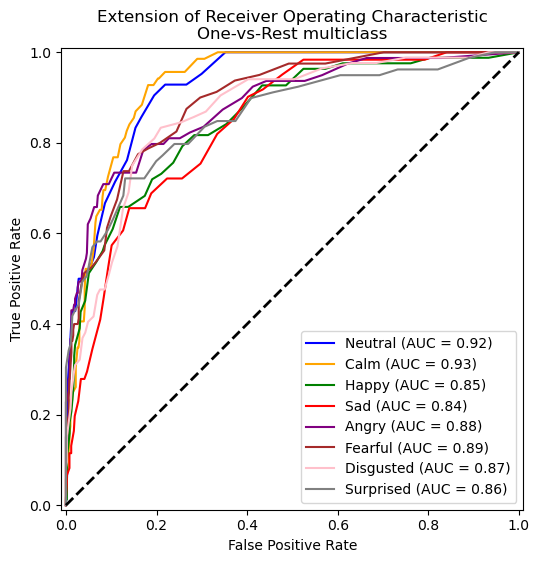

In [90]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

colors = cycle(["blue", "orange", "green", "red", "purple", "brown", "pink", "gray"])

fig, ax = plt.subplots(figsize=(6, 6))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nOne-vs-Rest multiclass"
)
#ax.legend(loc="lower right")

plt.show()

In [21]:
def generate_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    num_labels = len(unique_labels)
    conf_matrix = np.zeros((num_labels, num_labels), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        true_index = label_to_index[true_label]
        pred_index = label_to_index[pred_label]
        conf_matrix[true_index, pred_index] += 1

    return conf_matrix

In [ ]:
def confusion_matrix_vis1(conf_matrix: np.ndarray):
    _, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix)
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Actual Labels', fontsize=16)
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, str(val), ha='center', va='center', bbox=dict(
            boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title("Confusion Matrix on Eight Emotions")
    plt.show()
    return

In [109]:
def confusion_matrix_vis(conf_matrix: np.ndarray, target_names: list):
    _, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap="viridis")
    
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Actual Labels', fontsize=16)
    
    ax.set_xticks(range(len(target_names)))
    ax.set_yticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=45, ha="left", fontsize=12)
    ax.set_yticklabels(target_names, fontsize=12)
    
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, str(val), ha='center', va='center', bbox=dict(
            boxstyle='round', facecolor='white', edgecolor='0.3'))
    
    plt.title("Confusion Matrix on Eight Emotions", pad=20)
    plt.show()
    return

In [110]:
conf = generate_confusion_matrix(y_test, y_pred)

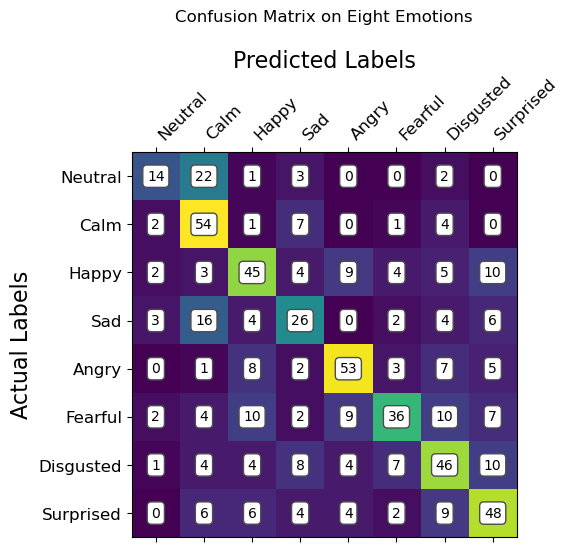

In [111]:
confusion_matrix_vis(conf, target_names=target_names)

In [29]:
from sklearn.metrics import classification_report

In [115]:
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

     Neutral       0.58      0.33      0.42        42
        Calm       0.49      0.78      0.60        69
       Happy       0.57      0.55      0.56        82
         Sad       0.46      0.43      0.44        61
       Angry       0.67      0.67      0.67        79
     Fearful       0.65      0.45      0.53        80
   Disgusted       0.53      0.55      0.54        84
   Surprised       0.56      0.61      0.58        79

    accuracy                           0.56       576
   macro avg       0.57      0.55      0.54       576
weighted avg       0.57      0.56      0.55       576



In [94]:
feature_selection_num = 20

importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

top_features = feature_importance_df['Feature'][:feature_selection_num].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [95]:
rf_selected = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf_selected.fit(X_train_selected, y_train)
y_score_selected = rf_selected.fit(X_train_selected, y_train).predict_proba(X_test_selected)
accuracy_selected_feature = rf_selected.score(X_test_selected, y_test)
print(f'Accuracy after feature selection: {accuracy_selected_feature:.2f}')


Accuracy after feature selection: 0.56


In [112]:
y_pred_selected = rf_selected.predict(X_test_selected)

In [113]:
conf_selected = generate_confusion_matrix(y_test, y_pred_selected)

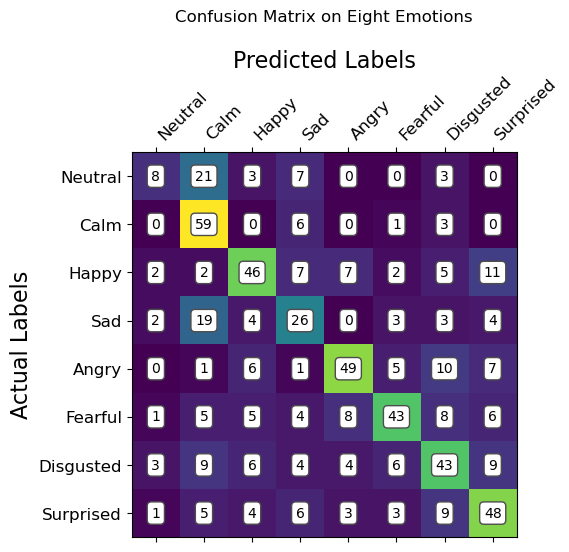

In [114]:
confusion_matrix_vis(conf_selected, target_names=target_names)

In [108]:
print(classification_report(y_test, y_pred_selected, target_names=target_names))
report_dict = classification_report(y_test, y_pred_selected, target_names=target_names, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

def highlight_bold_border(s):
    is_separator = s.name == "Surprised"  # Adjust row name here
    return ['border-bottom: 3px solid black;' if is_separator else '' for _ in s]

# Apply the style
styled_report_df = report_df.style.apply(highlight_bold_border, axis=1)

# Display the styled DataFrame
styled_report_df

              precision    recall  f1-score   support

     Neutral       0.47      0.19      0.27        42
        Calm       0.49      0.86      0.62        69
       Happy       0.62      0.56      0.59        82
         Sad       0.43      0.43      0.43        61
       Angry       0.69      0.62      0.65        79
     Fearful       0.68      0.54      0.60        80
   Disgusted       0.51      0.51      0.51        84
   Surprised       0.56      0.61      0.59        79

    accuracy                           0.56       576
   macro avg       0.56      0.54      0.53       576
weighted avg       0.57      0.56      0.55       576



,precision,recall,f1-score,support
Neutral,0.470588,0.190476,0.271186,42.000000
Calm,0.487603,0.855072,0.621053,69.000000
Happy,0.621622,0.560976,0.589744,82.000000
Sad,0.426230,0.426230,0.426230,61.000000
Angry,0.690141,0.620253,0.653333,79.000000
Fearful,0.682540,0.537500,0.601399,80.000000
Disgusted,0.511905,0.511905,0.511905,84.000000
Surprised,0.564706,0.607595,0.585366,79.000000
accuracy,0.559028,0.559028,0.559028,0.559028
macro avg,0.556917,0.538751,0.532527,576.000000


In [101]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

lass_of_interest = 1
print("Classes:", label_binarizer.classes_)

class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)
class_id

Classes: [1 2 3 4 5 6 7 8]


array([0], dtype=int64)

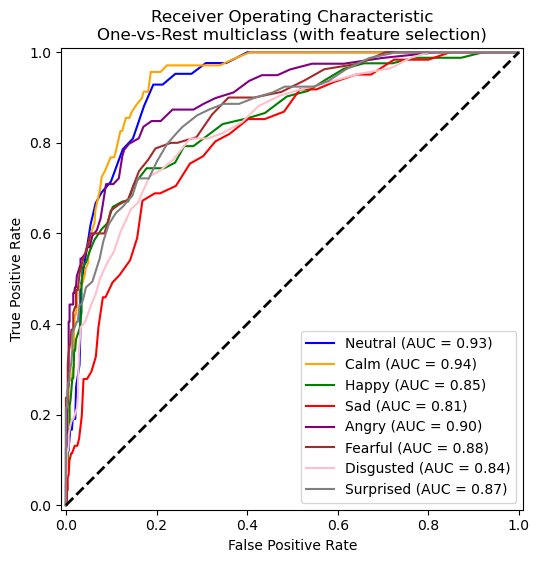

In [103]:
colors = cycle(["blue", "orange", "green", "red", "purple", "brown", "pink", "gray"])

fig, ax = plt.subplots(figsize=(6, 6))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score_selected[:, class_id],
        name=f"{target_names[class_id]}",
        color=color,
        ax=ax
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic\nOne-vs-Rest multiclass (with feature selection)"
)
#ax.legend(loc="lower right")

plt.show()